## Laboratorium 3 - algorytm *k* Najbliższych Sąsiadów (*k*NN)


### Opis
Celem laboratorium jest implementacja klasyfikatora *k* najbliższych sąsiadów - *k*NN (*k Nearest Neighbors*) oraz zapoznanie się z innymi metrykami klasyfikacji.


### Zbiór danych

Zbiór danych znajduje się w katalogu `dataset/*`. Jest to zmodyfikowany zbiór danych znajdujący się pod adresem: <https://archive.ics.uci.edu/ml/datasets/leaf>.

### Przesyłanie zadań

Wszystkie pliki należy spakować archiwizatorem **zip** i przesłać za pośrednictwem platformy WIKAMP. Poniżej oczekiwana zawartość archiwum:

```
+-- 📂 [IMIE.NAZWISKO].zip
    +-- 📜 Lab03.ipynb
    +-- 📂 dataset
        +-- 📜 dataset.npz
        +-- 📜 ReadMe.pdf
```

### Dodatkowe narzędzia

Dopuszczalne jest korzystanie z bibliotek: `numpy`, `pandas`, `matplotlib`.
Implementacja klasyfikatora powinna być wykonana bez wykorzystania zewnętrznych bibliotek.


### Zadanie

Należy wykonać następujące czynności w celu realizacji niniejszego zadania:
* Wczytaj dane.
* **Zaimplementuj klasyfikator *k* najbliższych sąsiadów (*k*NN)** i uruchom predykcję.
* Opisz jak zmieniają się wyniki klasyfikatora dla różnych wartości *k*, dla różnej liczby klas oraz dla różnej liczby cech.
* Wyświetl tablicę pomyłek (*confusion matrix*). W tym przypadku możesz zastosować gotową implementację z biblioteki `scikit-learn` <https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html>.
* Odszukaj przynajmniej dwie inne (niż accuracy) metryki przytatne w klasyfikacji na stronie <https://scikit-learn.org/stable/modules/model_evaluation.html> i opisz ich wyniki. Wytłumacz czym się różnią i co można z nich odczytać.
* Opisz różnicę wyników klasyfikacji obu algorytmów (NN i *k*NN)?


> UWAGA: Wszystkie wykonane elementy zadania powinny posiadać stosowne komentarze i opisy.

### PONIŻEJ WYKONAJ ZADANIE

In [2]:
# Importy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Wczytywanie danych

In [3]:
# Wczytywanie danych
with open('./dataset/dataset.npz', 'rb') as f:
    data = np.load(f)
    train, test = data['train'], data['test']

    train_y, train_x = np.hsplit(train, [1])
    test_y, test_x = np.hsplit(test, [1])
    
    train_y = train_y.flatten()
    test_y = test_y.flatten()

In [4]:
# Funkcja do filtrowania wybranych klas ze zbioru danych
def filter_classes(classes):
    train_indexes = np.zeros((train.shape[0],), dtype=np.bool_)
    test_indexes = np.zeros((test.shape[0],), dtype=np.bool_)
    for class_ in classes:
        train_indexes |= train[:, 0] == class_
        test_indexes |= test[:, 0] == class_
    return train[train_indexes, 1:], test[test_indexes, 1:], train[train_indexes, 0], test[test_indexes, 0]

### Implementacja klasyfikatora

In [5]:
# Implementacja klasyfikatora kNN
from math import dist
from scipy.stats import mode

class KNNClassifier:

    def __init__(self, k, features=None):
        self.k = k
        self.features = features

    def fit(self, x, y):
        self.x = x[:, self.features] if self.features else x
        self.y = y

    def predict(self, xs):
        # dla wielu próbek
        xs = xs[:, self.features] if self.features else xs
        return np.array([self._predict_single(x) for x in xs])

    def _predict_single(self, x):
        # dla jednej próbki
        distances = self._calc_distances(x)
        sorted_indexes = np.argsort(distances)
        top_k_indexes = sorted_indexes[:self.k]
        classes = self.y[top_k_indexes]
        modals, _ = mode(classes)
        class_ = modals[0]
        return class_

    def _calc_distances(self, x):
        distances = np.apply_along_axis(lambda i: dist(i, x), 1, self.x)
        return distances


## Uruchomienie klasyfikatora

In [6]:
# Funckcja uruchamiająca klasyfikator dla zadanego k, liczby klas i wybranych cech
from sklearn.metrics import accuracy_score, balanced_accuracy_score, ConfusionMatrixDisplay, matthews_corrcoef

def perform_test(k, classes, features):
    train_x, test_x, train_y, test_y = filter_classes(classes)
    classifier = KNNClassifier(k=k, features=features)
    classifier.fit(train_x, train_y)
    predictions = classifier.predict(test_x)
    
    accuracy = accuracy_score(test_y, predictions)
    balanced_accuracy = balanced_accuracy_score(test_y, predictions)
    matthews = matthews_corrcoef(test_y, predictions)
    
    print(f'Accuracy: {accuracy:.2f}')
    print(f'Balanced Accuracy: {balanced_accuracy:.2f}')
    print(f'Matthews Correlation: {matthews:.2f}')
    
    # print(classification_report(test_y, predictions))
    
    ConfusionMatrixDisplay.from_predictions(test_y, predictions)

Accuracy: 0.41
Balanced Accuracy: 0.63
Matthews Correlation: 0.26


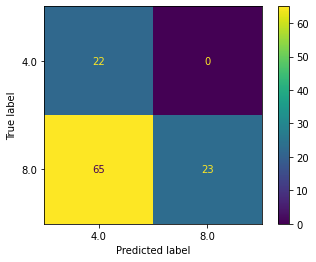

In [7]:
# Test klasyfikatora
perform_test(k=10, classes=[4, 8], features=[7, 4, 8, 9])

#### Accuracy
Dokładność to metryka, która mówi o jakości predykcji. Przyjmuję ona wartości pomiędzy 0.0 i 1.0, im wyższa wartość tym lepiej. Najlepiej się sprawdza, gdy w zbiorze znajduję się zbliżona liczba przykładów reprezentujących poszczególne klasy.

#### Balanced Accuracy
Zwykła dokładność (accuracy) jest podatna na zwracanie niewiarygodnych wyników, gdy liczba próbek reprezentujących poszczególne klasy znacząco się różni. Jej przewidywania są wówczas nazbyt optymistyczne. Metryka balanced accuracy rozwiązuję ten problem. Jest ona średnią arytmetyczną z czułości (sensitivity) i swoistości (specificity)

#### Matthews Correlation
Współczynnik korelacji mówiący o jakości predykcji, który jest odporny na niezrównoważone pod względem liczby klas zbiory danych. Przyjmuję wartości pomiędzy -1.0 i 1.0, gdzie 1 oznacza idealną predykcję, 0 całkowicie losową, a -1 przeciwną.

#### Macierz Pomyłek
Jest to macierz, która mówi jakie klasy przewidywane są dla próbek poszczególnych, rzeczywistych klas. Im wartości na przekątnej macierzy pomyłek są większe, tym rzadziej model się myli. W powyższym przypadku 22 próbki klasy 4 i 23 próbki klasy 8 zostały zakwalifikowane poprawnie. 64 próbki rzeczywistej klasy 8 zostały jednak zakwalifikowane nieprawidłowo jako klasa 4.

## Badanie różnej liczby klas

Accuracy: 1.00
Balanced Accuracy: 1.00
Matthews Correlation: 1.00


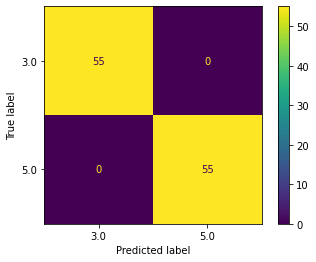

In [8]:
# 3 klasy
perform_test(k=10, classes=[3, 5], features=[3, 7])

Accuracy: 0.86
Balanced Accuracy: 0.86
Matthews Correlation: 0.82


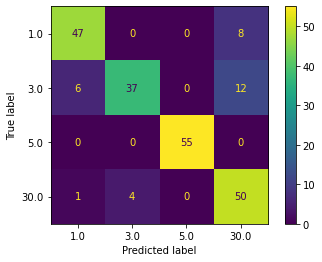

In [10]:
# 4 klasy
perform_test(k=10, classes=[1, 3, 5, 30], features=[3, 7])

Accuracy: 0.55
Balanced Accuracy: 0.51
Matthews Correlation: 0.51


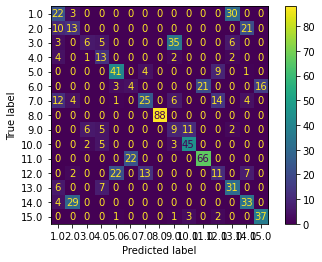

In [11]:
# 15 klas
perform_test(k=10, classes=list(range(1, 16)), features=[3, 7])

### Wnioski
Im większa liczba klas, tym dokładność modelu jest mnieja

## Badanie różnej liczby cech

Accuracy: 0.86
Balanced Accuracy: 0.86
Matthews Correlation: 0.82


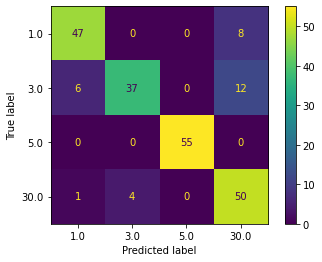

In [12]:
# 2 cechy
perform_test(k=10, classes=[1, 3, 5, 30], features=[3, 7])

Accuracy: 0.92
Balanced Accuracy: 0.92
Matthews Correlation: 0.89


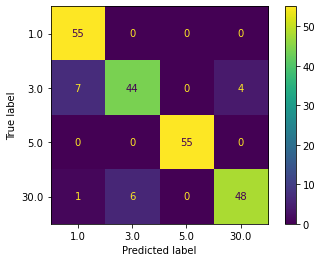

In [13]:
# 5 cech
perform_test(k=10, classes=[1, 3, 5, 30], features=[1, 2, 3, 7, 8])

Accuracy: 0.21
Balanced Accuracy: 0.21
Matthews Correlation: -0.06


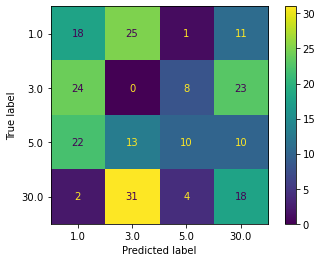

In [14]:
# 15 cech
perform_test(k=10, classes=[1, 3, 5, 30], features=list(range(15)))

### Wnioski
W celu najlepszej predykcji należy użyć jak najwięcej dyskryminatywnych cech. Gdy ich liczba została zwiększona z 2 do 5, to dokładność przewidywań również wzrosła. Gdy wykorzystano jednak wszystkie cechy, to dokładność okazała się bardzo niska, ponieważ nie wszystkie cechy były dyskryminatywne i utrudniały przez to klasyfikację.

## Badanie różnej liczby sąsiadów (k)

Accuracy: 0.88
Balanced Accuracy: 0.88
Matthews Correlation: 0.84


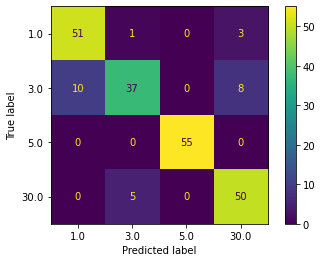

In [15]:
# k = 1
perform_test(k=1, classes=[1, 3, 5, 30], features=[1, 2, 3, 7, 8])

Accuracy: 0.90
Balanced Accuracy: 0.90
Matthews Correlation: 0.87


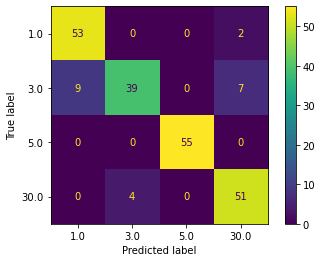

In [16]:
# k = 3
perform_test(k=3, classes=[1, 3, 5, 30], features=[1, 2, 3, 7, 8])

Accuracy: 0.93
Balanced Accuracy: 0.93
Matthews Correlation: 0.90


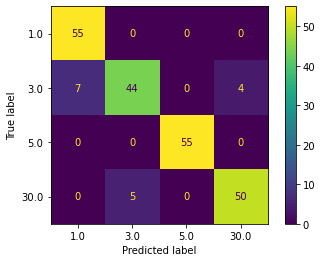

In [17]:
# k = 15
perform_test(k=15, classes=[1, 3, 5, 30], features=[1, 2, 3, 7, 8])

Accuracy: 0.85
Balanced Accuracy: 0.85
Matthews Correlation: 0.81


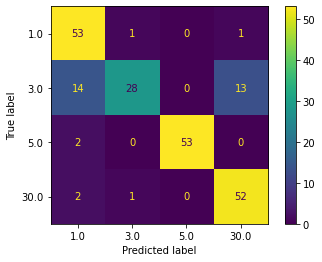

In [18]:
# k = 100
perform_test(k=100, classes=[1, 3, 5, 30], features=[1, 2, 3, 7, 8])

### Wnioski
Im k jest większe, tym klasyfikator jest mniej wrażliwy na szumy i pojedyncze przykłady uczące, lecz bierze pod uwagę większą ich liczbę. Powoduje to, że wraz ze zwiększaniem k dokładność klasyfikacji również rośnie, jednak do pewnej granicy. Gdy k jest zbyt duże to jakość klasyfikacji spada, ponieważ podczas predykcji brane są pod uwagę bardzo odległe przykłady uczące, które są w niewielkim stopniu już powiązane z badaną próbką.

## Porównanie klasyfikatorów KNN i NN
Klasyfikator NN to klasyfikator KNN z k = 1

Accuracy: 0.88
Balanced Accuracy: 0.88
Matthews Correlation: 0.84
------------------------------
Accuracy: 0.92
Balanced Accuracy: 0.92
Matthews Correlation: 0.89


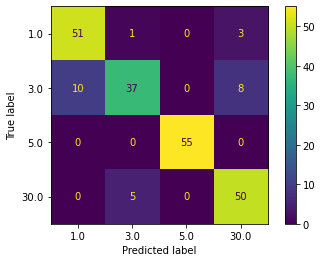

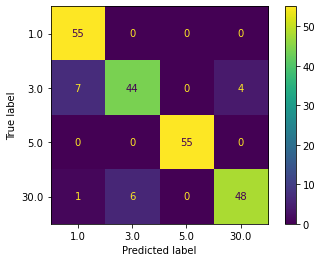

In [19]:
# 4 klasy; 4 cechy

classes = [1, 3, 5, 30]
features = [1, 2, 3, 7, 8]

perform_test(k=1, classes=classes, features=features)
print('-'*30)
perform_test(k=10, classes=classes, features=features)

Accuracy: 0.15
Balanced Accuracy: 0.15
Matthews Correlation: -0.14
------------------------------
Accuracy: 0.21
Balanced Accuracy: 0.21
Matthews Correlation: -0.06


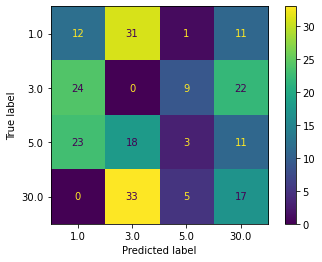

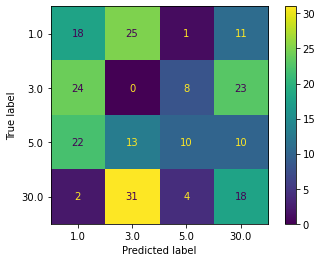

In [20]:
# 4 klasy; 15 cech

classes = [1, 3, 5, 30]
features = list(range(15))

perform_test(k=1, classes=classes, features=features)
print('-'*30)
perform_test(k=10, classes=classes, features=features)

Accuracy: 0.58
Balanced Accuracy: 0.54
Matthews Correlation: 0.55
------------------------------
Accuracy: 0.59
Balanced Accuracy: 0.55
Matthews Correlation: 0.56


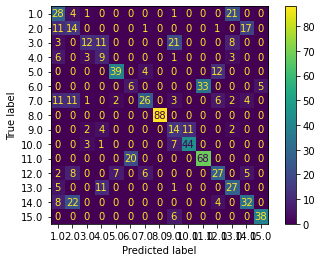

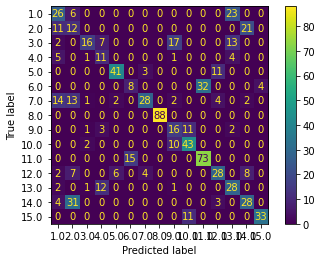

In [21]:
# 4 klasy; 4 cechy

classes = list(range(1, 16))
features = [1, 2, 3, 7, 8]

perform_test(k=1, classes=classes, features=features)
print('-'*30)
perform_test(k=10, classes=classes, features=features)

Accuracy: 0.25
Balanced Accuracy: 0.19
Matthews Correlation: 0.20
------------------------------
Accuracy: 0.28
Balanced Accuracy: 0.22
Matthews Correlation: 0.23


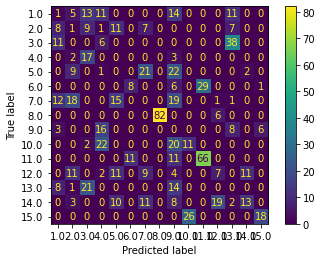

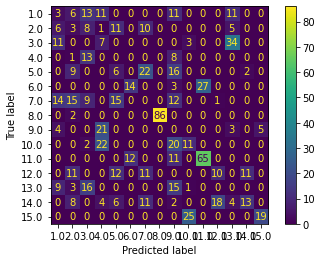

In [22]:
# 15 klas; 15 cech

classes = list(range(1, 16))
features = list(range(15))

perform_test(k=1, classes=classes, features=features)
print('-'*30)
perform_test(k=10, classes=classes, features=features)

### Wnioski
Klasyfikator KNN okazał się lepszy od klasyfikatora NN w każdym z rozważanych przypadków, pod względem wszystkich metryk. W niektórych testach różnica pomiędzy nimi była niewielka, lecz wciąż na korzyść klasyfikatora KNN. Klasyfikacja KNN powinna być ogólnie bardziej preferowana od NN.